# Data Assessment.

In [1]:
import pandas as pd
import numpy as np
import re
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
#Read csv file and show data frame

df = pd.read_csv('./Csv_Files/covidubatuba.csv')
df.head()

,Date,Mild,SARS,Positive,UnderObs.,Recovered,Deaths,Masc.,Fem.
0,25_NOVEMBRO_2021,27406,867,9110,7,8956,147,4096,5014
1,23-NOVEMBRO-2021,27302,863,9086,6,8933,147,4088,4998
2,18-NOVEMBRO-2021,27283,863,9086,6,8933,147,4088,4998
3,09-NOVEMBRO-2021,26695,857,8995,5,8843,147,4050,4945
4,04-NOVEMBRO-2021,26638,857,8995,6,8842,147,4050,4945


### Creating a DateTime object from "Date" column. 

In [3]:
#Split day-month-year from Date column format

date = df.iloc[:,0]
pattern = re.compile('([a-zA-Z]+)')
new = []
for i in date:
    match = re.split(pattern, i)
    if match == None:
        continue
    else:
        new.append(match)

In [4]:
#Check the result

new[0]

['25_', 'NOVEMBRO', '_2021']

In [5]:
#Create variables for new date

date_pat = re.compile('\d+')
day = [re.search(date_pat, i[0]).group() for i in new]
year = [re.search(date_pat, i[2]).group() for i in new]
month = [i[1].lower() for i in new]

In [6]:
#Change months to numerical format

date_dict = {'jan':'01','fev':'02','mar':'03','abr':'04','mai':'05','jun':'06','jul':'07','ago':'08','set':'09','out':'10','nov':'11','dez':'12'}
num_month = []
for i in month:
    for key, value in date_dict.items():
        if i.startswith(key):
            num_month.append(value)

In [7]:
#Merge the new features to create a DateTime object

df['Day'] = day
df['Month'] = num_month
df['Year'] = year
df['NewDate'] = df['Day']+'/'+df['Month']+'/'+df['Year']
df['Datetime'] = pd.to_datetime(df.NewDate, format= '%d/%m/%Y')
df.sort_values("Datetime", ascending=True, inplace=True, ignore_index=True)
idx = df.set_index('Datetime')

In [8]:
#Create a date indexed data frame

idx = df.set_index('Datetime')

In [9]:
#Check the indexed data frame

idx.head()

,Date,Mild,SARS,Positive,UnderObs.,Recovered,Deaths,Masc.,Fem.,Day,Month,Year,NewDate
Datetime,,,,,,,,,,,,,
2020-08-12,12-Ago-2020,2921,206,791,386,382,23,363,428,12,08,2020,12/08/2020
2020-08-13,13-Ago-2020,2966,208,814,401,390,23,378,436,13,08,2020,13/08/2020
2020-08-14,14-Ago-2020,3023,210,835,422,390,23,390,435,14,08,2020,14/08/2020
2020-08-15,15-Ago-2020,3030,210,841,428,390,23,393,438,15,08,2020,15/08/2020
2020-08-16,16-Ago-2020,3030,210,842,428,390,24,394,438,16,08,2020,16/08/2020


### Evaluating the data.

In [10]:
#Select features for a visual evaluation

idx = idx.iloc[:,1:-4]

<AxesSubplot:xlabel='Datetime'>

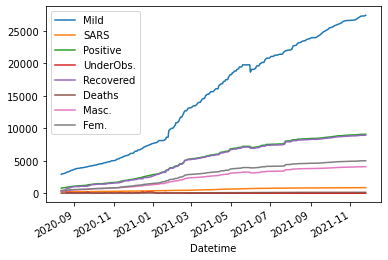

In [11]:
#Plot features

idx.plot(kind="line")

There are apparent deviations in these series, accumulated values should not decrease at any time, as in this dataset.

In [12]:
#Check if the features are strictly increasing

for column in idx:
    v = idx[column]
    print(column+":", all(a<=b for a,b in zip(v, v[1:])))

Mild: False
SARS: True
Positive: False
UnderObs.: False
Recovered: False
Deaths: False
Masc.: False
Fem.: False


It makes sense that "UnderObs." varies up and down,  and "SARS" is strictly increasing, as it should. I'll let them both out of the repair data frame.  

In [13]:
#Select the problematic features 

repair = idx.copy()
repair = repair.iloc[:,np.r_[:1,2:3,4:8]]

In [14]:
#Check repair data frame

repair.head()

,Mild,Positive,Recovered,Deaths,Masc.,Fem.
Datetime,,,,,,
2020-08-12,2921,791,382,23,363,428
2020-08-13,2966,814,390,23,378,436
2020-08-14,3023,835,390,23,390,435
2020-08-15,3030,841,390,23,393,438
2020-08-16,3030,842,390,24,394,438


In [15]:
#Find out their locations and how much each value is descending  

dates = []
for column in repair:
    col = repair[column]
    date = [str(i).split(" ")[0] for i in col.index.to_list()]
    diff = col.diff().fillna(0).astype(int)
    zipped = [i for i in zip(date, diff)]
    
    for i,v in enumerate(zipped):
        if v[1] >= 0:
            continue
        else:
            dates.append(v[0])
            print(column+"   id:"+str(i)+" | date:"+v[0]+" | diff:"+str(v[1]))

Mild   id:222 | date:2021-05-31 | diff:-1117
Mild   id:226 | date:2021-06-04 | diff:-1
Positive   id:222 | date:2021-05-31 | diff:-188
Recovered   id:44 | date:2020-10-23 | diff:-1
Recovered   id:126 | date:2021-02-24 | diff:-18
Recovered   id:192 | date:2021-05-01 | diff:-1
Recovered   id:222 | date:2021-05-31 | diff:-190
Deaths   id:306 | date:2021-10-26 | diff:-1
Masc.   id:222 | date:2021-05-31 | diff:-133
Fem.   id:2 | date:2020-08-14 | diff:-1
Fem.   id:25 | date:2020-09-21 | diff:-5
Fem.   id:222 | date:2021-05-31 | diff:-55


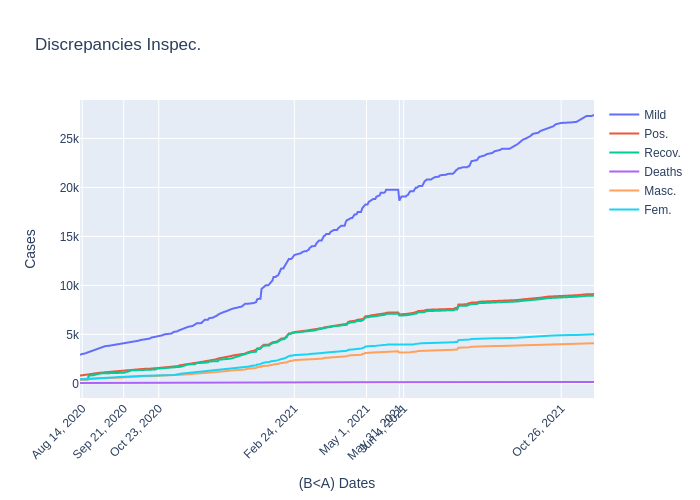

In [16]:
#Plot an interactive visualization of the features, using dates where values are decreasing as "xticks". 

fig = go.Figure()

fig.add_trace(go.Scatter(x=repair.index, y=repair.Mild, name="Mild"))
fig.add_trace(go.Scatter(x=repair.index, y=repair.Positive, name="Pos."))
fig.add_trace(go.Scatter(x=repair.index, y=repair.Recovered, name="Recov."))
fig.add_trace(go.Scatter(x=repair.index, y=repair.Deaths, name="Deaths"))
fig.add_trace(go.Scatter(x=repair.index, y=repair["Masc."], name="Masc."))
fig.add_trace(go.Scatter(x=repair.index, y=repair["Fem."], name="Fem."))

fig.update_layout(
        title="Discrepancies Inspec.",
        yaxis_title="Cases", 
        xaxis= dict(
            tickmode='array', 
            tickvals = list(set(dates)),
            tickangle=-45,
            title="(B<A) Dates"
        )
)
fig.show("png")

### Repairing deviations.

In [17]:
#Set new values for "Mild" column 

repair.loc["2021-01-25":"2021-05-30", "Mild"] = repair.loc["2021-01-25":"2021-05-30", "Mild"] - 1000
repair.loc["2021-05-31", "Mild"] = repair.loc["2021-05-31", "Mild"] + 117
repair.loc["2021-06-04":"2021-06-06", "Mild"] = repair.loc["2021-06-04":"2021-06-06", "Mild"] + 1

In [18]:
#Set new values for "Positive" column

repair.loc["2021-05-31":"2021-07-23", "Positive"] = repair.loc["2021-05-31":"2021-07-23", "Positive"] + 188

In [19]:
#Set new values for "Recovered" column

repair.loc["2020-10-23", "Recovered"] = repair.loc["2020-10-23", "Recovered"] + 1
repair.loc["2021-02-24", "Recovered"] = repair.loc["2021-02-24", "Recovered"] + 18
repair.loc["2021-02-25", "Recovered"] = repair.loc["2021-02-25", "Recovered"] + 9
repair.loc["2021-05-01":"2021-05-02", "Recovered"] = repair.loc["2021-05-01":"2021-05-02", "Recovered"] + 1
repair.loc["2021-05-31":"2021-07-23", "Recovered"] = repair.loc["2021-05-31":"2021-07-23", "Recovered"] + 190

In [20]:
#Set new values for "Deaths" column

repair.loc["2021-10-26":, "Deaths"] = repair.loc["2021-10-26":, "Deaths"] + 1

In [21]:
#Set new values for "Masc." column

repair.loc["2021-05-31":"2021-07-23", "Masc."] = repair.loc["2021-05-31":"2021-07-23", "Masc."] + 133

In [22]:
#Set new values for "Fem." column

repair.loc["2020-08-14", "Fem."] = repair.loc["2020-08-14", "Fem."] + 1
repair.loc["2020-09-21", "Fem."] = repair.loc["2020-09-21", "Fem."] + 5
repair.loc["2021-05-31":"2021-07-23", "Fem."] = repair.loc["2021-05-31":"2021-07-23", "Fem."] + 55

### Checking the changes.

<AxesSubplot:xlabel='Datetime'>

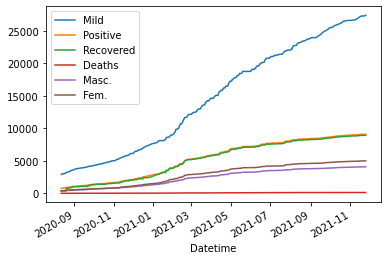

In [23]:
#Plot the repaired features

repair.plot(kind="line")

In [24]:
#Check if the features are strictly increasing

for column in repair:
    v = repair[column]
    print(column+":", all(a<=b for a,b in zip(v, v[1:])))

Mild: True
Positive: True
Recovered: True
Deaths: True
Masc.: True
Fem.: True


In [25]:
#Rename "repair" data frame features and join them to the previous frame for a comparison

keys = [i for i in repair.columns]
values = [i+"_r" for i in keys]
repair = repair.rename(columns=dict(zip(keys,values)))
compare = idx.join(repair)

In [26]:
#Slice "affected areas" of the features for a better visualization

m = compare.loc["2020-12-10":"2021-07-15"]
p = compare.loc["2021-04-17":"2021-09-08"]
d = compare.loc["2021-10-05":]

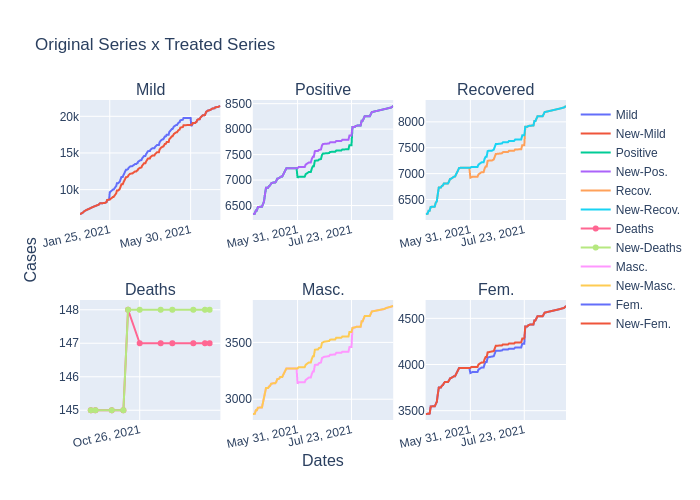

In [27]:
#Plot a comparison of "original x new" for each repaired series

fig = make_subplots(
    rows=2,cols=3,
    subplot_titles=("Mild","Positive","Recovered","Deaths","Masc.","Fem."),
    row_heights=[7,7],
    y_title="Cases",
    x_title="Dates"
)
fig.add_trace(go.Scatter(x=m.index,y=m.Mild,name="Mild"),row=1,col=1)
fig.add_trace(go.Scatter(x=m.index,y=m.Mild_r,name="New-Mild"),row=1,col=1)
fig.update_xaxes(tickmode='array',tickvals=["2021-01-25","2021-05-30"],row=1,col=1)
fig.add_trace(go.Scatter(x=p.index,y=p.Positive,name="Positive"),row=1,col=2)
fig.add_trace(go.Scatter(x=p.index,y=p.Positive_r,name="New-Pos."),row=1,col=2)
fig.update_xaxes(tickmode='array',tickvals=["2021-05-31","2021-07-23"],row=1,col=2)
fig.add_trace(go.Scatter(x=p.index,y=p.Recovered,name="Recov."),row=1,col=3)
fig.add_trace(go.Scatter(x=p.index,y=p.Recovered_r,name="New-Recov."),row=1,col=3)
fig.update_xaxes(tickmode='array',tickvals=["2021-05-31","2021-07-23"],row=1,col=3)
fig.add_trace(go.Scatter(x=d.index,y=d.Deaths,name="Deaths"),row=2,col=1)
fig.add_trace(go.Scatter(x=d.index,y=d.Deaths_r,name="New-Deaths"),row=2,col=1)
fig.update_xaxes(tickmode='array',tickvals=["2021-10-26"],row=2,col=1)
fig.add_trace(go.Scatter(x=p.index,y=p["Masc."],name="Masc."),row=2,col=2)
fig.add_trace(go.Scatter(x=p.index,y=p["Masc._r"],name="New-Masc."),row=2,col=2)
fig.update_xaxes(tickmode='array',tickvals=["2021-05-31","2021-07-23"],row=2,col=2)
fig.add_trace(go.Scatter(x=p.index,y=p["Fem."],name="Fem."),row=2,col=3)
fig.add_trace(go.Scatter(x=p.index,y=p["Fem._r"],name="New-Fem."),row=2,col=3)
fig.update_xaxes(tickmode='array',tickvals=["2021-05-31","2021-07-23"],row=2,col=3)

fig.update_xaxes(
    tickangle=-12
)
fig.update_layout(
    title="Original Series x Treated Series"
)
fig.show("png")

### Building a treated data frame.

In [28]:
#Add the remaining features to the data frame and create a "treated" one 

repair["SARS"] = idx.SARS
repair["UnderObs."] = idx["UnderObs."]
treated = repair.iloc[:,np.r_[0,-2,1,-1,2:6]]
keys = [i for i in treated.columns]
values = [i for i in idx.columns]
treated = treated.rename(columns=dict(zip(keys,values)))

In [29]:
#Display some information about the new data frame

treated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 312 entries, 2020-08-12 to 2021-11-25
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Mild       312 non-null    int64
 1   SARS       312 non-null    int64
 2   Positive   312 non-null    int64
 3   UnderObs.  312 non-null    int64
 4   Recovered  312 non-null    int64
 5   Deaths     312 non-null    int64
 6   Masc.      312 non-null    int64
 7   Fem.       312 non-null    int64
dtypes: int64(8)
memory usage: 31.9 KB


In [30]:
#Save it to a csv file 

#treated.to_csv("./Csv_Files/treated_df.csv")

&nbsp;The data shows anomalies, some numbers have changed abruptly in one day, and there are large offsets for 5 of the 7 variables which should strictly be increasing.  
&nbsp;On January 25, 2021, the “Mild” series experienced a sudden increase, returning to a sharp drop on May 31, 2021, the same date that the other four series suddenly dropped. "Positive", "Recovered", "Masc" and "Fem" increase again on July 23, 2021, all at once.